# Life & Health Reinsurance Analytics Project

## Project Objective
This project demonstrates my understanding of:
- Life and health insurance risk modeling
- Reinsurance structures and their impact on portfolio risk
- Capital and tail risk metrics
- Analytical storytelling using Python and Jupyter notebooks

The goal is to build a synthetic life and health insurance portfolio,
simulate losses, apply reinsurance structures, and analyze the impact
on volatility and capital requirements.


## Portfolio Overview

The portfolio consists of two blocks of business:

### Life Insurance
- Individual life policies
- Mortality-driven claims
- Low frequency, high severity

### Health Insurance
- Individual health policies
- Morbidity-driven claims
- High frequency, lower severity

Synthetic data is used throughout the project to focus on modeling
logic rather than data availability.


## Scope and Key Metrics

The analysis focuses on:
- Annual loss distributions
- Monte Carlo simulation
- Gross vs net losses
- Value-at-Risk (99.5%) as a proxy for regulatory capital
- Volatility reduction due to reinsurance


In [1]:
# Import required packages
import pandas as pd
import numpy as np

# Portfolio parameters
n_life_policies = 10000
n_health_policies = 5000

life_age_range = (30, 70)
life_sum_assured_range = (50000, 300000)

health_age_range = (18, 65)
health_sum_assured_range = (5000, 50000)

print("Portfolio parameters set successfully.")


Portfolio parameters set successfully.


## Life Insurance Loss Simulation

We will simulate **annual life insurance losses** using a Monte Carlo approach.

Assumptions:
- Each policy has an **age** and **sum assured**.
- Mortality rate increases with age (exponential curve).
- Deaths are simulated as **Bernoulli events** based on mortality rate.
- Annual losses are the **sum of sum assured for all deaths**.

This simulation will produce a **distribution of losses**, which we can later use for reinsurance and capital analysis.


In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate ages for life policies
life_ages = np.random.randint(life_age_range[0], life_age_range[1]+1, n_life_policies)

# Generate sum assured for each policy
life_sum_assured = np.random.uniform(life_sum_assured_range[0], life_sum_assured_range[1], n_life_policies)

# Define a simple mortality curve: q_x = alpha * exp(beta * (age - 40))
alpha = 0.0005
beta = 0.08
life_mortality_rates = np.clip(alpha * np.exp(beta * (life_ages - 40)), 0, 1)

# Create portfolio DataFrame
life_portfolio = pd.DataFrame({
    "age": life_ages,
    "sum_assured": life_sum_assured,
    "mortality_rate": life_mortality_rates
})

# Preview portfolio
life_portfolio.head()


,age,sum_assured,mortality_rate
0,68,109805.803416,0.004697
1,58,153803.439171,0.002110
2,44,203772.821842,0.000689
3,37,170297.037869,0.000393
4,50,164875.566643,0.001113


**Portfolio Columns:**
- `age` — age of policyholder
- `sum_assured` — payout if death occurs
- `mortality_rate` — probability of death this year

We are now ready to **simulate annual losses** using this portfolio.


In [3]:
n_simulations = 5000
losses = np.zeros(n_simulations)

for i in range(n_simulations):
    # Simulate deaths for each policy
    deaths = np.random.binomial(1, life_portfolio["mortality_rate"])
    # Calculate total loss for this simulation
    losses[i] = (deaths * life_portfolio["sum_assured"]).sum()

# Convert to pandas Series for easy analysis
losses = pd.Series(losses)

# Quick statistics
print(f"Mean annual loss: {losses.mean():,.0f}")
print(f"Max annual loss: {losses.max():,.0f}")
print(f"99.5% VaR (proxy for regulatory capital): {losses.quantile(0.995):,.0f}")


Mean annual loss: 2,912,333
Max annual loss: 6,451,011
99.5% VaR (proxy for regulatory capital): 5,156,786


**Monte Carlo Loss Simulation Output**

- `Mean annual loss` — expected payout
- `Max annual loss` — extreme scenario observed in simulations
- `99.5% VaR` — value at risk at 99.5% confidence, a common regulatory metric


## Visualizing Life Insurance Loss Distribution

We can plot the histogram of simulated losses to see:
- Shape of the distribution
- Extreme loss scenarios
- Tail risk visually


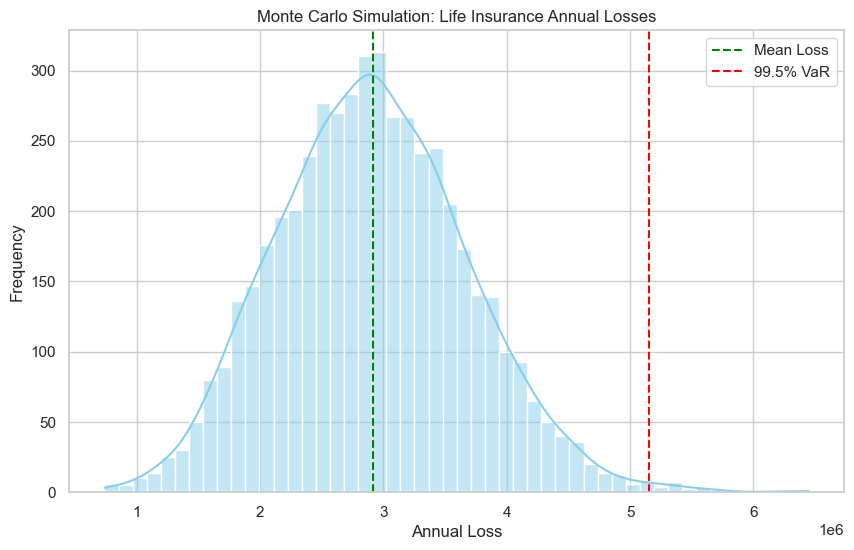

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(10,6))
sns.histplot(losses, bins=50, kde=True, color="skyblue")
plt.axvline(losses.mean(), color='green', linestyle='--', label='Mean Loss')
plt.axvline(losses.quantile(0.995), color='red', linestyle='--', label='99.5% VaR')
plt.title("Monte Carlo Simulation: Life Insurance Annual Losses")
plt.xlabel("Annual Loss")
plt.ylabel("Frequency")
plt.legend()
plt.show()
